In [ ]:
#we divide image into patches then give as sequence, not giving pixel by pixel as sequence as it will very computational
#expensive
#lke image is 256x256x3 so we convert to 16x16x3 patches
#this 16x16 is 256 size feature vector that in nlp represent word but here represent patch
#then we do linear projecttion means converting 256 vector to 512 dimension
#then add positional embeddings, CNN have inductive bias as the consider position of pixels, but for transformer we
#add this position embeddings, and this has to be learned automatically(because output of encoder sent to MLP head so reduce
#bias we do this that add learnable embedding)

#MLP have 2 dense layers with GELU non linearity

In [ ]:
#here instead of doing batch normalization we do layer norm that is feature norm
#as batch statists for NLP have larger variance and this exist in gradient also

In [ ]:
#we get seq*dim output from transformer

In [ ]:
#it can happen that we need to fine tune vit on higher resolution like on 512x512 so patches will be more if
#same size patch so positional embedding useeless that is pretrained so we can apply 2D interpolation technique for
#that

In [ ]:
#for reduce number of samples resnet is better but for large number of samples vit outperforms
#vits outperform covo when larger data

#as to vit we give patch so for vit feel difficult to learn with small number of samples

#and with larger samples vit learns to proper do position embeddings

#as we increase depth of vit more global picture in image will be captured

In [ ]:
#we can visualisulize attention so that can interpret results

In [ ]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

In [70]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["Cat", "Dog"],
}

In [ ]:
test_image= cv2.imread('/content/yoloImage.jpeg')
test_image= cv2.resize(test_image, (256, 256))

In [ ]:
test_image.shape

(256, 256, 3)

In [ ]:
patches=tf.image.extract_patches(images=tf.expand_dims(test_image, axis=0),
                          sizes=[1, 16, 16, 1], #for size of patches
                          strides=[1, 16, 16, 1], #for how much window move for getting patch
                          rates=[1, 1, 1, 1], #it is used for dilated convolution
                          padding='VALID')

In [ ]:
patches.shape #as 16*16*3= 768 that why as 3 colors in image

TensorShape([1, 16, 16, 768])

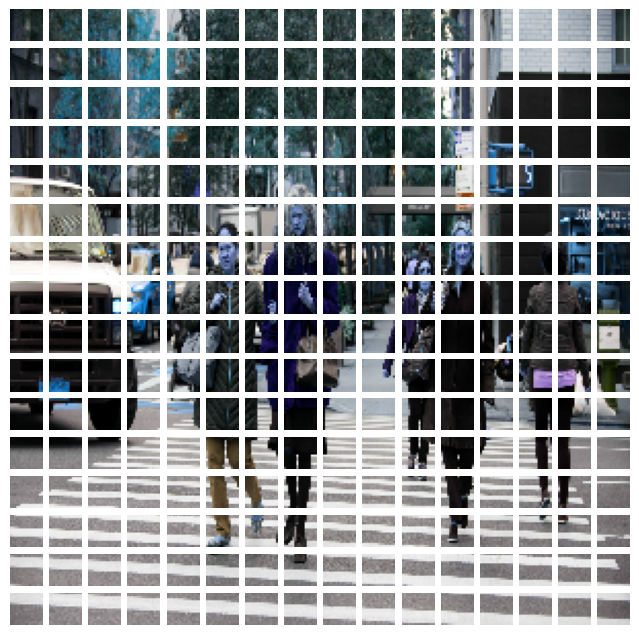

In [ ]:
plt.figure(figsize = (8,8))
k=0
for i in range (16):
  for j in range (16):
    ax = plt.subplot (16,16, k+1)
    plt.imshow(tf.reshape(patches[0, i,j,:], (16, 16,3)))
    plt.axis("off")
    k+=1

In [ ]:
#becuase we represent in feature vector
patches = tf.reshape (patches, (patches.shape [0], -1, 768))
print(patches.shape)

(1, 256, 768)


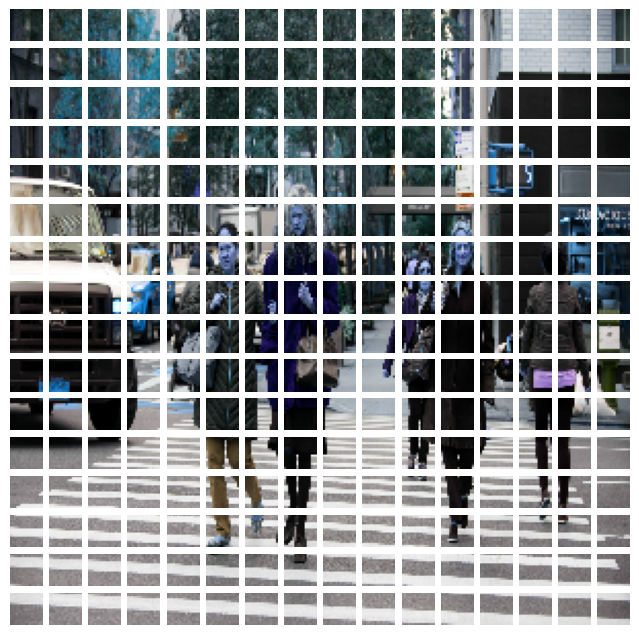

In [ ]:
plt.figure(figsize = (8,8))
for i in range(patches.shape [1]):
  ax = plt. subplot (16,16, i+1)
  plt.imshow(tf.reshape(patches[0, i, :], (16, 16,3)))
  plt.axis("off")

In [ ]:
HIDDEN_SIZE=512
N_PATCHES=256

class PatchEncoder(tf.keras.layers.Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = tf.keras.layers.Dense(HIDDEN_SIZE) #for linear projection

    self.positional_embedding = tf.keras.layers.Embedding(N_PATCHES, HIDDEN_SIZE ) #it convert +ve int to dense vector
    #in this we dont have vocab size so put patches number here
    #in embedding layer we dont add bias only x*w not +b
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images=x,
        #sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        sizes=[1, 16, 16, 1],
        strides=[1, 16, 16, 1],
        rates=[1, 1, 1, 1],
        padding='VALID')

    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1])) #for converting to proper dimension
    #batchsize*seq*featurevector

    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 ) #here we are generating numbers between 0 and 1
    #equal to numberof patches and then we give this embedding layer then add to patches embedding
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

    return output

In [ ]:
patch_encoder= PatchEncoder(256, 512)
patch_encoder(tf.zeros([1,256,256,3]))

<tf.Tensor: shape=(1, 256, 512), dtype=float32, numpy=
array([[[ 0.04276016, -0.04939885,  0.01759399, ..., -0.02437027,
          0.02896987, -0.04129303],
        [ 0.02770375,  0.04096447, -0.04156965, ..., -0.04652314,
          0.04975982, -0.00617009],
        [-0.0495529 ,  0.02052975,  0.04511135, ...,  0.03713972,
          0.04308093, -0.02073982],
        ...,
        [-0.02118013,  0.01084037,  0.01436595, ...,  0.0314788 ,
          0.03690438,  0.01436926],
        [ 0.0369211 ,  0.01409248, -0.04094381, ..., -0.01168408,
         -0.03292501,  0.02602341],
        [ 0.02985822, -0.03501391, -0.03874488, ...,  0.00218469,
         -0.00479419, -0.00497022]]], dtype=float32)>

In [ ]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = tf.keras.layers.LayerNormalization()
    self.layer_norm_2 = tf.keras.layers.LayerNormalization()

    self.multi_head_att = tf.keras.layers.MultiHeadAttention(N_HEADS, HIDDEN_SIZE )

    self.dense_1 = tf.keras.layers.Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = tf.keras.layers.Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1) #we have to give query and key in this, atleast two inputs

    x_1 = tf.keras.layers.Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = tf.keras.layers.Add()([output, x_1])

    return output

In [ ]:
te= TransformerEncoder(8, 512)
te(tf.zeros([1,256,512]))

<tf.Tensor: shape=(1, 256, 512), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [ ]:
class ViT(tf.keras.Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = tf.keras.layers.Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = tf.keras.layers.Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = tf.keras.layers.Dense(2, activation = 'softmax')
  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = tf.keras.layers.Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [ ]:
vit = ViT(
    N_HEADS = 1, HIDDEN_SIZE = 512, N_PATCHES = 256,
    N_LAYERS = 1, N_DENSE_UNITS = 128)


vit(tf.zeros([2,256,256,3]))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.4937229 , 0.5062771 ],
       [0.49372292, 0.5062771 ]], dtype=float32)>

In [ ]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncode  multiple                  524800    
 r)                                                              
                                                                 
 transformer_encoder (Trans  multiple                  1577984   
 formerEncoder)                                                  
                                                                 
 dense_6 (Dense)             multiple                  16777344  
                                                                 
 dense_7 (Dense)             multiple                  16512     
                                                                 
 dense_8 (Dense)             multiple                  258       
                                                                 
Total params: 18896898 (72.09 MB)
Trainable para

In [77]:
(ds_train), ds_info = tfds. load (
    "cats_vs_dogs", #it is name that is in catelog of link above
    split=["train"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,

)

In [78]:
ds_train=ds_train[0]

In [79]:
for i, j in ds_train.take(2):
  print(i.shape,j)

(316, 300, 3) tf.Tensor(0, shape=(), dtype=int64)
(500, 375, 3) tf.Tensor(1, shape=(), dtype=int64)


In [80]:
# fig = tfds.show_examples (ds_train, ds_info, rows=4, cols=4)

In [81]:
def normalize_image(image, label):
  image=tf.image.resize(image, (256,256))
  return tf.cast(image, tf.float32)/255.0, label

AUTOTUNE=tf.data.experimental.AUTOTUNE #tf allow us to give this to set automatically
BATCH_SIZE=1

ds_train=ds_train.map(normalize_image, num_parallel_calls=AUTOTUNE) # in normalize function these is no sequence so
#process can be done paralelly
ds_train= ds_train.cache() #it keep next data in memory so it will be fast
ds_train=ds_train.shuffle(1000) #we can give 1000 so it will see 1000 datat points but
#it depends on records in a file so take from that
ds_train=ds_train.batch(BATCH_SIZE)
ds_train=ds_train.prefetch(AUTOTUNE) #it keeps 64 examples ready when running on gpu the current one



In [82]:
ds_train=ds_train.take(10)

In [ ]:
vit.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"],
)
vit.fit(ds_train, epochs=3)

Epoch 1/3
364/364 - 291s - loss: 3.4157 - accuracy: 0.5546 - 291s/epoch - 800ms/step
Epoch 2/3
364/364 - 286s - loss: 0.6553 - accuracy: 0.6193 - 286s/epoch - 786ms/step
Epoch 3/3
364/364 - 287s - loss: 0.6250 - accuracy: 0.6543 - 287s/epoch - 788ms/step


In [ ]:
#need very very large dataset for vit to outperform cnn

In [ ]:
#now using hugging face vits

In [ ]:
#HuggingFace ViT
!pip install transformers

In [ ]:
from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig(hidden_size=144)

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [ ]:
configuration

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 144,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.41.1"
}

In [ ]:
resize_rescale_hf = tf.keras.Sequential([
       tf.keras.layers.Resizing(224, 224),
       tf.keras.layers.Rescaling(1./255),
       tf.keras.layers.Permute((3,1,2))
])

In [ ]:
from transformers import AutoImageProcessor, TFViTModel


base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = tf.keras.layers.Input(shape = (256, 256, 3)) #model want input in this shape so we need
#to add layer that convert our input image to like this format
x=resize_rescale_hf(inputs)
x= base_model.vit(x)[0][:, 0, :] #for last hidden state [0]
#but for classsification purpose we need only first embedding as it is designed to have all in first patch [:, 0, :]

hf_model = tf.keras.Model(inputs=inputs, outputs=x)

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
hf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                                
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0     

In [ ]:
for i, j in ds_train.take(1):
  print(i.shape, j.shape)

(3, 256, 256, 3) (3,)


In [ ]:
t=tf.expand_dims(i[0], axis=0)

In [ ]:
hf_model(t) #for getting attentn mask and all hidden outputs we need to give that in config

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 1.60007462e-01,  3.16793695e-02, -2.59445626e-02,
        -7.72444755e-02, -5.60633913e-02,  8.97749290e-02,
         2.78075226e-02,  1.16269141e-01,  1.07420087e-02,
        -3.36775810e-01, -1.14336967e-01, -1.05196238e-01,
         9.94876549e-02,  1.39526755e-01, -2.70858765e-01,
         1.49101883e-01,  2.11999580e-01, -8.79656002e-02,
         1.15849018e-01,  3.86853367e-02, -1.13318376e-01,
        -8.83353651e-02, -7.85655454e-02,  1.11208394e-01,
        -1.45170420e-01, -1.50682867e-01,  2.01684803e-01,
        -1.05064549e-03, -1.79362111e-02, -1.82995453e-01,
        -1.54240698e-01, -4.04028222e-02, -9.33357552e-02,
         2.27024168e-01, -2.21870393e-02, -2.45386809e-01,
         1.03350990e-02, -1.16376448e-02, -2.21061260e-02,
        -9.01778936e-02, -1.97588474e-01, -7.92518333e-02,
         1.46834686e-01, -2.85450399e-01, -1.50172621e-01,
         4.11310568e-02, -1.62468985e-01,  1.51693881e-01,
      

In [ ]:
base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = tf.keras.layers.Input(shape = (256, 256, 3))
x=resize_rescale_hf(inputs)
x= base_model.vit(x)[0][:, 0, :]
output = tf.keras.layers.Dense(2, activation = 'softmax')(x)
hf_model = tf.keras.Model(inputs=inputs, outputs=output)


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
#for fine tuning we need to have very small learning rate, remmember this

In [ ]:
hf_model(t)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.41610223, 0.58389777]], dtype=float32)>

In [ ]:
hf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"],
)

In [ ]:
hf_model.fit(ds_train, epochs=30)

Epoch 1/30


1/1 [==============================] - 89s 89s/step - loss: 0.7651 - accuracy: 0.3333
Epoch 2/30
1/1 [==============================] - 8s 8s/step - loss: 0.6376 - accuracy: 0.6667
Epoch 3/30
1/1 [==============================] - 7s 7s/step - loss: 0.6605 - accuracy: 0.6667
Epoch 4/30
1/1 [==============================] - 9s 9s/step - loss: 0.6376 - accuracy: 0.6667
Epoch 5/30
1/1 [==============================] - 8s 8s/step - loss: 0.6381 - accuracy: 0.6667
Epoch 6/30
1/1 [==============================] - 8s 8s/step - loss: 0.6405 - accuracy: 0.6667
Epoch 7/30
1/1 [==============================] - 7s 7s/step - loss: 0.6373 - accuracy: 0.6667
Epoch 8/30
1/1 [==============================] - 8s 8s/step - loss: 0.6357 - accuracy: 0.6667
Epoch 9/30
1/1 [==============================] - 7s 7s/step - loss: 0.6370 - accuracy: 0.6667
Epoch 10/30
1/1 [==============================] - 8s 8s/step - loss: 0.6375 - accuracy: 0.6667
Epoch 11/30
1/1 [==============================] - 9s 9s/s

In [ ]:
!pip install wandb

In [ ]:
import wandb
from tensorflow import keras

In [ ]:
from wandb.keras import WandbCallback

In [ ]:
!wandb login

# !wandb login --relogin

wandb: Currently logged in as: khandanu777 (daniyaljmi777). Use `wandb login --relogin` to force relogin


In [ ]:
wandb.init(project="transformers", entity="daniyaljmi777", reinit=True)

wandb: Currently logged in as: khandanu777 (daniyaljmi777). Use `wandb login --relogin` to force relogin


In [ ]:
wandb.config = {
"BATCH_SIZE": 32,
"IM _SIZE": 256,
"LEARNING_RATE": 5e-5,
"N_EPOCHS": 20,
"DROPOUT_RATE": 0.0,
"REGULARIZATION_RATE": 0.0,
"N_FILTERS": 6,
"KERNEL_SIZE": 3,
"N_STRIDES": 1,
"POOL_SIZE": 2,
"N_DENSE_1": 1024,
"N_DENSE_2": 128,
"NUM _CLASSES": 3,
"PATCH_SIZE": 16,
"PROJ_DIM": 768,
"CLASS_NAMES": ["cat", "dog"],
}
CONFIGURATION = wandb.config

In [ ]:
hf_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=5e-5),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"],
)

In [ ]:
hf_model.fit(ds_train, epochs=30, callbacks=[WandbCallback()])

Epoch 1/30
1/1 [==============================] - 26s 26s/step - loss: 0.6306 - accuracy: 0.8000
Epoch 2/30
1/1 [==============================] - 9s 9s/step - loss: 0.6288 - accuracy: 0.8000
Epoch 3/30
1/1 [==============================] - 7s 7s/step - loss: 0.6271 - accuracy: 0.8000
Epoch 4/30
1/1 [==============================] - 7s 7s/step - loss: 0.6253 - accuracy: 0.8000
Epoch 5/30
1/1 [==============================] - 9s 9s/step - loss: 0.6236 - accuracy: 0.8000
Epoch 6/30
1/1 [==============================] - 7s 7s/step - loss: 0.6219 - accuracy: 0.8000
Epoch 7/30
1/1 [==============================] - 9s 9s/step - loss: 0.6202 - accuracy: 0.8000
Epoch 8/30
1/1 [==============================] - 8s 8s/step - loss: 0.6185 - accuracy: 0.8000
Epoch 9/30
1/1 [==============================] - 7s 7s/step - loss: 0.6168 - accuracy: 0.8000
Epoch 10/30
1/1 [==============================] - 9s 9s/step - loss: 0.6152 - accuracy: 0.8000
Epoch 11/30
1/1 [==============================

In [112]:

class LogConfMatrix(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in ds_train:
      predicted.append(hf_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.array([i[0] for i in labels])

    #in wandb site we get this code for ploting different plots
    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=CONFIGURATION["CLASS_NAMES"])

    wandb.log({"conf_mat": cm})

In [111]:
class LogResultsTable(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):

    columns=["image", "Predicted", "Label"]

    val_table = wandb.Table(columns = columns)


    for im, label in ds_train:

      pred = CONFIGURATION["CLASS_NAMES"][tf.argmax(hf_model(im), axis = -1).numpy()[0]]
      label = CONFIGURATION["CLASS_NAMES"][label.numpy()[0]]

      row = [wandb.Image(im), pred, label]

      val_table.add_data(*row) #we add row to table we created


    wandb.log({"Model Results" : val_table})

In [113]:
hf_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=5e-5),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"],
)

hf_model.fit(ds_train, epochs=3, callbacks=[WandbCallback(), LogConfMatrix(), LogResultsTable()])

Epoch 1/3
10/10 [==============================] - 89s 8s/step - loss: 0.6789 - accuracy: 0.7000
Epoch 2/3
10/10 [==============================] - 51s 5s/step - loss: 0.6960 - accuracy: 0.5000
Epoch 3/3
10/10 [==============================] - 72s 8s/step - loss: 0.6845 - accuracy: 0.6000


In [114]:
#Get Attention Maps

In [ ]:
from transformers import ViTFeatureExtractor, TFViTModel, ViTConfig

configuration = ViTConfig()
configuration.output_attentions = True

base_model = TFViTModel.from_pretrained(
    pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k",
    config = configuration,
    )
inputs = Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)['attentions']

model = tf.keras.Model(inputs=inputs, outputs=x)